# 糖尿病预测数据预处理与建模（基于 BRFSS 数据集）

本 Notebook 包括以下模块：

- 数据划分与标准化  
- 类别分布检查与上采样  
- 标准化可视化  
- XGBoost 模型训练与评估  


In [2]:
import os
from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score
from xgboost import plot_importance
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance
# 基础库
import numpy as np
import pandas as pd

# 机器学习
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                           accuracy_score, precision_recall_curve, roc_auc_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 树模型
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier  # 需要单独安装：pip install lightgbm

# 可视化
import matplotlib.pyplot as plt
import seaborn as sns

# 对数据进行预处理

In [3]:


# 🔶 2. 读取原始 CSV
df = pd.read_csv('data/CDC_BRFSS2015.csv')

# 🔶 3. 字段重命名（便于统一命名）
df.columns = [
    'Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
    'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
    'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth',
    'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income'
]

# 🔶 4. 处理异常值（如极端 BMI）
df = df[df['BMI'] <= 60]

# 🔶 5. 构造新特征（仅在允许字段内）
df['IsObese'] = (df['BMI'] >= 30).astype(int)

# 不健康得分强化表达（考虑行动困难放大效果）
df['HealthRiskScore'] = (df['MentHlth'] + df['PhysHlth']) * (df['DiffWalk'] + 1)

# 🔶 6. 加强现有字段的表达能力（不新增字段名）

# BMI 加权表达肥胖风险（保持字段名）
df['BMI'] = df['BMI'] * (1 + 0.2 * df['IsObese'])

# Age、Education、Income 归一化（树模型可选，但对神经网络更敏感）
scaler = MinMaxScaler()
df[['Age', 'Education', 'Income']] = scaler.fit_transform(df[['Age', 'Education', 'Income']])

# HealthRiskScore 归一化
df[['HealthRiskScore']] = scaler.fit_transform(df[['HealthRiskScore']])

# 🔶 7. 最终保留字段（严格不添加新字段）
final_cols = [
    'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
    'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
    'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk',
    'Sex', 'Age', 'Education', 'Income', 'BMI', 'IsObese', 'HealthRiskScore',
    'Diabetes_binary'
]
df_final = df[final_cols]

# 🔶 8. 保存结果
df_final.to_csv('aftprocessdata/processed_brfss.csv', index=False)
print("✅ 已生成优化后的文件：processed_brfss.csv")



✅ 已生成优化后的文件：processed_brfss.csv


# 加载数据（请确保已预处理为 processed_brfss.csv）

In [4]:

data = pd.read_csv('aftprocessdata/processed_brfss.csv')
data.head()
#类别数量检查
print("Class 0:", (data.iloc[:,-1] == 0).sum())
print("Class 1:", (data.iloc[:,-1] == 1).sum())


Class 0: 217700
Class 1: 35175


# 上采样函数定义与执行
复制少数类样本使其数量增加到与多数类相等，这样可以平衡训练数据的正负样本数量；


In [7]:
def oversample(df):
    if ((df.iloc[:,-1] == 0).sum()) >= ((df.iloc[:,-1] == 1).sum()):
        df_majority = df[df.iloc[:,-1] == 0]
        df_minority = df[df.iloc[:,-1] == 1]
    else:
        df_majority = df[df.iloc[:,-1] == 1]
        df_minority = df[df.iloc[:,-1] == 0]
    df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    return df_upsampled.sample(frac=1, random_state=0).reset_index(drop=True)

# 执行上采样
data_balanced = oversample(data)
data_balanced['Diabetes_binary'].value_counts()


Diabetes_binary
0.0    217700
1.0    217700
Name: count, dtype: int64

# 数据划分以及标准化

In [8]:
def data_split(df):
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

def data_scaling(train_x, test_x):
    scaler = StandardScaler()
    train_x_scaled = scaler.fit_transform(train_x)
    test_x_scaled = scaler.transform(test_x)
    return train_x_scaled, test_x_scaled

# 执行划分与标准化
train_x, test_x, train_y, test_y = data_split(data_balanced)
train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)


# 创建训练集，测试集，验证集

In [10]:
import numpy as np
import pandas as pd
# 1. 读取数据
df = pd.read_csv('aftprocessdata/processed_brfss.csv')

# 2. 拆分特征和标签
X = df.drop(columns=['Diabetes_binary'])
y = df['Diabetes_binary']

# 3. 先划分为训练集（70%）和临时集（30%）
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 4. 临时集再划分为验证集和测试集（各15%）
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# 5. 只对训练集做上采样
train_df = pd.concat([X_train, y_train], axis=1)

df_majority = train_df[train_df['Diabetes_binary'] == 0]
df_minority = train_df[train_df['Diabetes_binary'] == 1]

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

train_upsampled = pd.concat([df_majority, df_minority_upsampled])
train_upsampled = train_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

X_train_upsampled = train_upsampled.drop(columns=['Diabetes_binary'])
y_train_upsampled = train_upsampled['Diabetes_binary']

# 6. 验证集欠采样，调整为正负类1:1比例
val_df = pd.concat([X_val.reset_index(drop=True), y_val.reset_index(drop=True)], axis=1)
val_majority = val_df[val_df['Diabetes_binary'] == 0]
val_minority = val_df[val_df['Diabetes_binary'] == 1]

val_minority_size = min(len(val_majority), len(val_minority))
val_majority_downsampled = resample(val_majority, replace=False, n_samples=val_minority_size, random_state=42)
val_minority_downsampled = val_minority.sample(n=val_minority_size, random_state=42)

val_balanced = pd.concat([val_majority_downsampled, val_minority_downsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

X_val_balanced = val_balanced.drop(columns=['Diabetes_binary'])
y_val_balanced = val_balanced['Diabetes_binary']

# 7. 测试集欠采样，调整为正负类1:1比例
test_df = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
test_majority = test_df[test_df['Diabetes_binary'] == 0]
test_minority = test_df[test_df['Diabetes_binary'] == 1]

test_minority_size = min(len(test_majority), len(test_minority))
test_majority_downsampled = resample(test_majority, replace=False, n_samples=test_minority_size, random_state=42)
test_minority_downsampled = test_minority.sample(n=test_minority_size, random_state=42)

test_balanced = pd.concat([test_majority_downsampled, test_minority_downsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

X_test_balanced = test_balanced.drop(columns=['Diabetes_binary'])
y_test_balanced = test_balanced['Diabetes_binary']

# 8. 输出样本数及类别分布，确认效果
print(f"训练集样本数（上采样后）：{len(X_train_upsampled)}")
print(train_upsampled['Diabetes_binary'].value_counts())

print(f"验证集样本数（欠采样后）：{len(X_val_balanced)}")
print(y_val_balanced.value_counts())

print(f"测试集样本数（欠采样后）：{len(X_test_balanced)}")
print(y_test_balanced.value_counts())

# 9. 保存处理后的数据
X_train_upsampled.to_csv("sign/X_train.csv", index=False)
y_train_upsampled.to_csv("sign/y_train.csv", index=False)

X_val_balanced.to_csv("sign/X_val.csv", index=False)
y_val_balanced.to_csv("sign/y_val.csv", index=False)

X_test_balanced.to_csv("sign/X_test.csv", index=False)
y_test_balanced.to_csv("sign/y_test.csv", index=False)

训练集样本数（上采样后）：304780
Diabetes_binary
0.0    152390
1.0    152390
Name: count, dtype: int64
验证集样本数（欠采样后）：10552
Diabetes_binary
0.0    5276
1.0    5276
Name: count, dtype: int64
测试集样本数（欠采样后）：10554
Diabetes_binary
0.0    5277
1.0    5277
Name: count, dtype: int64


In [11]:
# 1. 读数据
X_train = pd.read_csv("sign/X_train.csv")
y_train = pd.read_csv("sign/y_train.csv").values.ravel()
X_val = pd.read_csv("sign/X_val.csv")
y_val = pd.read_csv("sign/y_val.csv").values.ravel()
X_test = pd.read_csv("sign/X_test.csv")
y_test = pd.read_csv("sign/y_test.csv").values.ravel()

# 2. 模型初始化，加入正则化和early stopping参数
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    n_estimators=5000,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=3,
    reg_alpha=0.1,
    reg_lambda=1,
    eval_metric='auc',
)

lgb_model = LGBMClassifier(
    objective='binary',
    random_state=42,
    n_estimators=10000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=2,
    reg_alpha=0.1,
    reg_lambda=1
)

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# 3. 先分别训练XGB和LGB，加early stopping
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=100
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
)

# 4. 随机森林直接训练（无early stopping）
rf_model.fit(X_train, y_train)

# 5. 用验证集预测概率，评估性能，计算各模型的AUC或F1给投票赋权（这里用简单的accuracy示例）
from sklearn.metrics import roc_auc_score

xgb_val_pred = xgb_model.predict_proba(X_val)[:,1]
lgb_val_pred = lgb_model.predict_proba(X_val)[:,1]
rf_val_pred = rf_model.predict_proba(X_val)[:,1]

xgb_auc = roc_auc_score(y_val, xgb_val_pred)
lgb_auc = roc_auc_score(y_val, lgb_val_pred)
rf_auc = roc_auc_score(y_val, rf_val_pred)

print(f"验证集AUC: XGB={xgb_auc:.4f}, LGB={lgb_auc:.4f}, RF={rf_auc:.4f}")

# 6. 根据AUC给投票赋权，比例大致按AUC大小调整
weights = [xgb_auc*10, lgb_auc*10, rf_auc*10]

voting_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgb', lgb_model),
        ('rf', rf_model)
    ],
    voting='soft',
    weights=weights,
    n_jobs=-1
)

# 7. 投票模型训练（其实各个模型已训练好，VotingClassifier会用已训练模型预测）
# 但为了接口完整，先fit一次
voting_model.fit(X_train, y_train)

# 8. 测试集预测概率
y_proba = voting_model.predict_proba(X_test)[:,1]

# 9. 找最佳阈值
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"最佳F1阈值: {best_threshold:.4f}，对应F1: {f1_scores[best_idx]:.4f}")

# 10. 选定阈值预测
y_pred = (y_proba >= best_threshold).astype(int)

# 11. 最终评估
print("\n测试集分类报告：")
print(classification_report(y_test, y_pred))
print("混淆矩阵：")
print(confusion_matrix(y_test, y_pred))
print("准确率:", accuracy_score(y_test, y_pred))



[0]	validation_0-auc:0.78418
[100]	validation_0-auc:0.80735
[200]	validation_0-auc:0.81097
[300]	validation_0-auc:0.81407
[400]	validation_0-auc:0.81566
[500]	validation_0-auc:0.81641
[600]	validation_0-auc:0.81675
[700]	validation_0-auc:0.81698
[800]	validation_0-auc:0.81698
[900]	validation_0-auc:0.81700
[1000]	validation_0-auc:0.81700
[1100]	validation_0-auc:0.81690
[1200]	validation_0-auc:0.81680
[1300]	validation_0-auc:0.81670
[1400]	validation_0-auc:0.81656
[1500]	validation_0-auc:0.81645
[1600]	validation_0-auc:0.81629
[1700]	validation_0-auc:0.81618
[1800]	validation_0-auc:0.81602
[1900]	validation_0-auc:0.81591
[2000]	validation_0-auc:0.81576
[2100]	validation_0-auc:0.81563
[2200]	validation_0-auc:0.81546
[2300]	validation_0-auc:0.81529
[2400]	validation_0-auc:0.81516
[2500]	validation_0-auc:0.81505
[2600]	validation_0-auc:0.81491
[2700]	validation_0-auc:0.81473
[2800]	validation_0-auc:0.81462
[2900]	validation_0-auc:0.81447
[3000]	validation_0-auc:0.81433
[3100]	validation_0-

KeyboardInterrupt: 

# 评估和可视化


XGBoost 模型评估结果
准确率(Accuracy): 0.7414
精确率(Precision): 0.7218
召回率(Recall): 0.7854
F1分数: 0.7523
AUC分数: 0.8169

分类报告:
              precision    recall  f1-score   support

         0.0       0.76      0.70      0.73     43540
         1.0       0.72      0.79      0.75     43540

    accuracy                           0.74     87080
   macro avg       0.74      0.74      0.74     87080
weighted avg       0.74      0.74      0.74     87080



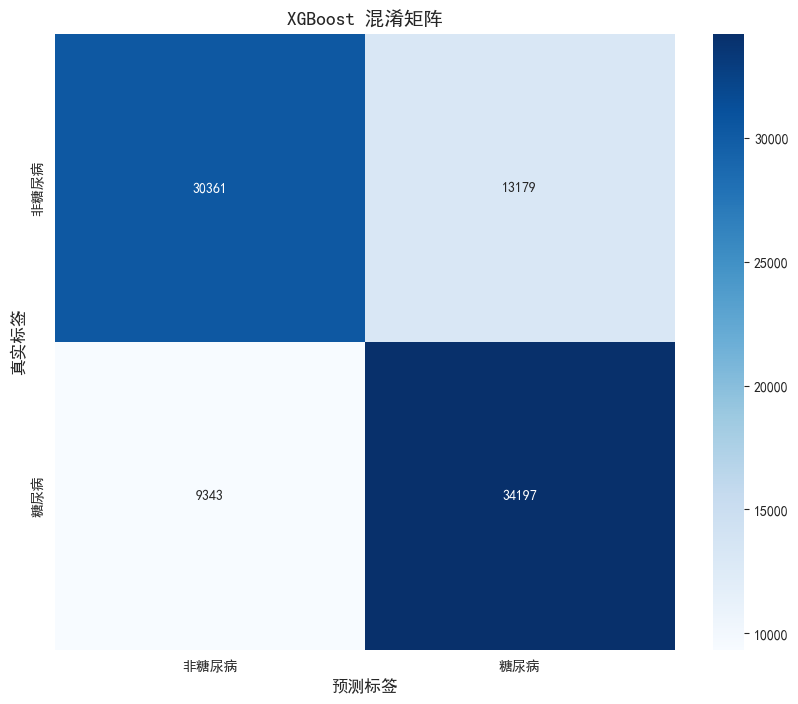

<Figure size 1200x800 with 0 Axes>

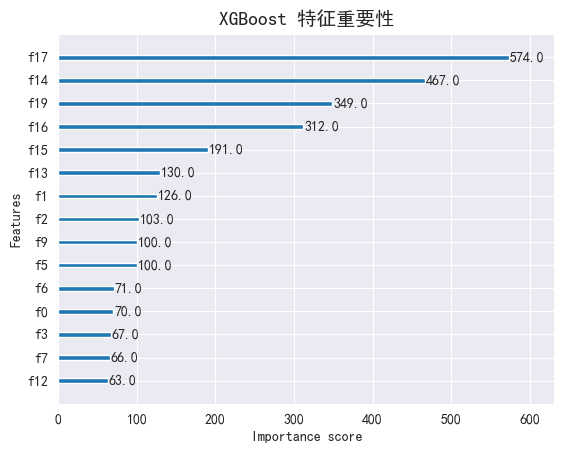


验证集评估结果:
              precision    recall  f1-score   support

         0.0       0.68      0.82      0.74      5276
         1.0       0.77      0.61      0.68      5276

    accuracy                           0.71     10552
   macro avg       0.72      0.71      0.71     10552
weighted avg       0.72      0.71      0.71     10552



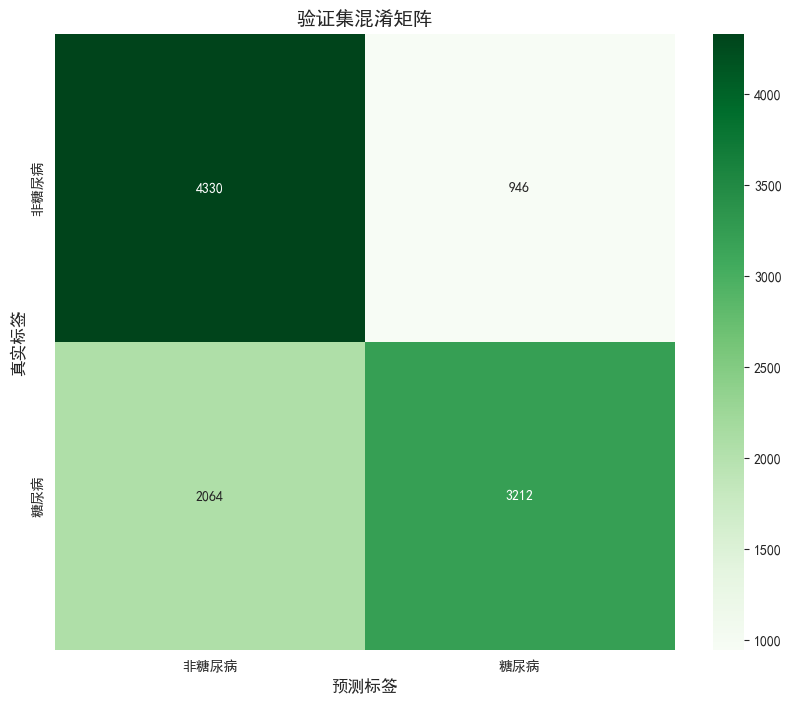

In [13]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文显示字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题


def train_and_evaluate(X_train, y_train, X_test, y_test, model_name="XGBoost"):
    """
    训练模型并生成评估指标和可视化
    参数:
        X_train: 训练集特征
        y_train: 训练集标签
        X_test: 测试集特征
        y_test: 测试集真实标签
        model_name: 模型名称(用于标题显示)
    """
    # 1. 初始化并训练XGBoost模型
    model = XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss'
    )

    model.fit(X_train, y_train)

    # 2. 预测
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # 预测概率(用于AUC)

    # 3. 计算评估指标
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"\n{'=' * 40}")
    print(f"{model_name} 模型评估结果")
    print(f"{'=' * 40}")
    print(f"准确率(Accuracy): {accuracy:.4f}")
    print(f"精确率(Precision): {precision:.4f}")
    print(f"召回率(Recall): {recall:.4f}")
    print(f"F1分数: {f1:.4f}")
    print(f"AUC分数: {roc_auc:.4f}")
    print("\n分类报告:")
    print(classification_report(y_test, y_pred))

    # 4. 可视化 - 混淆矩阵
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['非糖尿病', '糖尿病'],
                yticklabels=['非糖尿病', '糖尿病'])
    plt.title(f'{model_name} 混淆矩阵', fontsize=14)
    plt.xlabel('预测标签', fontsize=12)
    plt.ylabel('真实标签', fontsize=12)
    plt.savefig(f'results/{model_name}_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 5. 可视化 - 特征重要性
    plt.figure(figsize=(12, 8))
    plot_importance(model, max_num_features=15)
    plt.title(f'{model_name} 特征重要性', fontsize=14)
    plt.savefig(f'results/{model_name}_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    return model


# 执行模型训练与评估

# 确保结果目录存在
import os

os.makedirs('results', exist_ok=True)

# 使用标准化后的数据训练
model = train_and_evaluate(train_x_scaled, train_y, test_x_scaled, test_y)

# 使用验证集进行最终评估（可选）

# 加载之前保存的验证集
X_val = pd.read_csv("sign/X_val.csv")
y_val = pd.read_csv("sign/y_val.csv").squeeze()

# 对验证集进行相同的标准化处理
scaler = StandardScaler()
X_train_full = scaler.fit_transform(pd.concat([X_train, X_val]))  # 使用全部训练数据拟合scaler
X_val_scaled = scaler.transform(X_val)

# 在验证集上评估
print("\n验证集评估结果:")
y_val_pred = model.predict(X_val_scaled)
print(classification_report(y_val, y_val_pred))

# 验证集混淆矩阵
plt.figure(figsize=(10, 8))
cm_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens',
            xticklabels=['非糖尿病', '糖尿病'],
            yticklabels=['非糖尿病', '糖尿病'])
plt.title('验证集混淆矩阵', fontsize=14)
plt.xlabel('预测标签', fontsize=12)
plt.ylabel('真实标签', fontsize=12)
plt.savefig('results/validation_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()